# Videogame Playability analysis with PySpark Using Players Reviews

## Big Data Computing final project - A.Y. 2022-2023

Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author

Ilaria De Sio - [desio.2064970@studenti.uniroma1.it](mailto:desio.2064970@studenti.uniroma1.it)

The project is based on the paper entitled *A Data-Driven Approach for Video Game
Playability Analysis Based on Players’ Reviews* in this case study, the definition of
playability analyzed consists of three basic concepts ”**functionality**, **usability**, and
**gameplay**” defined by the *framework of Paavilainen*.

The goal is to obtain an explicit
and simplified framework so that not only the intuitively quantified assessment of the
overall playability of the chosen game is obtained but also to analyze and be able
to view the information
that can be ”playability-informative” and ”non-playability-informative” divided into
the classes listed above.

## Define some global constants

In [1]:
# GITHUB
DATASET_URL = "https://raw.githubusercontent.com/iladesio/iladesio/Video_Game_Playability_Analysis/tree/main/dataset/data_clean.csv"
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
# GOOGLE DRIVE
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR  # Your own home directory

# File Variable
GDRIVE_DATASET_FILE = GDRIVE_HOME_DIR + "/" + DATASET_URL.split("/")[-1]

In [2]:
!pip install pyspark==3.3.0 spark-nlp==2.4.5
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME
!pip install gdown
!gdown https://drive.google.com/uc?id=1z6yNubY3Ban-dADPpTTV9-Q_Fd-rM1p1 -O data_clean.csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764012 sha256=e23f5721b5632b32ab47766391986534dea223564a158c84f5a6e4258400c70d
  Stored in directory: /root/.cache/pip/wheels/81/9c/6c/d5200fcf351ffa39cbe09911e99703283624cd037df58070d9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The

## Import PySpark packages and other dependencies

In [3]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark import SparkContext, SparkConf

from pyspark.ml import Pipeline
import re

import nltk
from nltk import *
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set("spark.kryoserializer.buffer.max", "2000M").\
                set("spark.jars.packages","com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.3").\
                setAppName("ProjectBigData").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
print(sc)
spark = SparkSession.builder.getOrCreate()

<SparkContext master=local[*] appName=ProjectBigData>


#1) Dataset initialization
I chose to use the dataset [https://doi.org/10.6084/m9.figshare.14222531.v1](https://doi.org/10.6084/m9.figshare.14222531.v1) directly provided by the authors of the paper containing the review data from Steam for **No Man’s Sky** in terms of playability by users.
This case of study is really interesting because this game was released on 2016, before which a social media “hype” had been evoked leading to an unprecedentedly high expectation.
Unexpectedly the release was disastrous, but for the last four years, the
game has been continuously maintained with its quality gradually increasing, which makes it a unique case where the changes in game quality is observable.



In [5]:
game_dataset = spark.read.csv('data_clean.csv', header=True, inferSchema=True)
game_dataset.show(n=5)

+--------------------+--------+--------------------+-------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------+
|    recommendationid|language|              review|  timestamp_created|  timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks| author_last_played|
+--------------------+--------+--------------------+-------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+----------------

In [6]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(game_dataset.count(), len(game_dataset.columns)))

The shape of the dataset is 273742 rows by 18 columns


## 1.1) Dataset Shape and Scheme

* ```recommendationid```: The review ID;
* ```language```: Review language;
* ```review```: The text of user review;
* ```timestamp_created ```: The date a review is posted;
* ```timestamp_updated```: Update date of a review;
* ```voted_up```: True means it was a positive recommendation;
* ```votes_up```: The number of other users who found this review helpful;
* ```votes_funny```: How many other player think the review is funny;
* ```weighted_cote_score```: Helpfulness score;
* ```comment_count```: How many other player comment the review;
* ```steam_purchase```: Game purchased on steam or not;
* ```received_for_free```: Game received for free or not;
* ```written_during_early_access```: True if the review was written during early access;
* ```author_num_games_owned```: Number of games owned by the author;
* ```author_num_reviews```: How many other reviews has this user done;
* ```author_playtime_forever```: Number of total hours played by the author;
* ```author_playtime_last_two_weeks```: Number of hours played by the author in the last two weeks;
* ```author_last_played```: Date of the last time the user played the game;

-------





Cast the columns `"written_during_early_access", "voted_up", "steam_purchase"` from String to boolean

In [7]:
game_dataset = game_dataset.withColumn('written_during_early_access', f.col('written_during_early_access').cast('boolean')) \
    .withColumn('voted_up', f.col('voted_up').cast('boolean')) \
    .withColumn('steam_purchase', f.col('steam_purchase').cast('boolean'))


Cast the columns `"author_num_games_owned", "author_num_reviews", "author_playtime_forever" and "author_playtime_last_two_weeks"`from String to Integer

In [8]:
game_dataset = game_dataset.withColumn('author_num_games_owned', f.col('author_num_games_owned').cast(IntegerType())) \
    .withColumn('author_num_reviews', f.col('author_num_reviews').cast(IntegerType())) \
    .withColumn('author_playtime_forever', f.col('author_playtime_forever').cast(IntegerType())) \
    .withColumn('author_playtime_last_two_weeks', f.col('author_playtime_last_two_weeks').cast(IntegerType()))

In [9]:
game_dataset.printSchema();

root
 |-- recommendationid: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: boolean (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_last_played: string (nullable = true)



#2) Data Pre-processing
In this phase involves cleaning and transforming the raw data to ensure its quality and compatibility with the analysis.



## 2.1) Data Cleaning

From the data info above, we can already notice that there are missing values in review. Since our work is going to be heavily relying on this column, we have to clean it from these missing values. In addition, we also need to check for duplicated values following the standard data cleaning procedure.

In [10]:
missing_counts = [game_dataset.where(f.col(c).isNull()).count() for c in game_dataset.columns]
for c, count in zip(game_dataset.columns, missing_counts):
    print("N. of missing values of column `{}` = {}".format(c, count))

N. of missing values of column `recommendationid` = 7
N. of missing values of column `language` = 78805
N. of missing values of column `review` = 102986
N. of missing values of column `timestamp_created` = 153423
N. of missing values of column `timestamp_updated` = 162127
N. of missing values of column `voted_up` = 188991
N. of missing values of column `votes_up` = 171107
N. of missing values of column `votes_funny` = 173328
N. of missing values of column `weighted_vote_score` = 174789
N. of missing values of column `comment_count` = 175753
N. of missing values of column `steam_purchase` = 180423
N. of missing values of column `received_for_free` = 176888
N. of missing values of column `written_during_early_access` = 201392
N. of missing values of column `author_num_games_owned` = 183027
N. of missing values of column `author_num_reviews` = 181025
N. of missing values of column `author_playtime_forever` = 196880
N. of missing values of column `author_playtime_last_two_weeks` = 203931
N

In [11]:
# Delete rows containing null values from the DataFrame.
game_dataset = game_dataset.na.drop()

game_dataset.show(n=5)

+----------------+--------+--------------------+-------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------+
|recommendationid|language|              review|  timestamp_created|  timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks| author_last_played|
+----------------+--------+--------------------+-------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------+
|      

In [12]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(game_dataset.count(), len(game_dataset.columns)))

The shape of the dataset is 64757 rows by 18 columns


In [13]:
missing_counts = [game_dataset.where(f.col(c).isNull()).count() for c in game_dataset.columns]
for c, count in zip(game_dataset.columns, missing_counts):
    print("N. of missing values of column `{}` = {}".format(c, count))

N. of missing values of column `recommendationid` = 0
N. of missing values of column `language` = 0
N. of missing values of column `review` = 0
N. of missing values of column `timestamp_created` = 0
N. of missing values of column `timestamp_updated` = 0
N. of missing values of column `voted_up` = 0
N. of missing values of column `votes_up` = 0
N. of missing values of column `votes_funny` = 0
N. of missing values of column `weighted_vote_score` = 0
N. of missing values of column `comment_count` = 0
N. of missing values of column `steam_purchase` = 0
N. of missing values of column `received_for_free` = 0
N. of missing values of column `written_during_early_access` = 0
N. of missing values of column `author_num_games_owned` = 0
N. of missing values of column `author_num_reviews` = 0
N. of missing values of column `author_playtime_forever` = 0
N. of missing values of column `author_playtime_last_two_weeks` = 0
N. of missing values of column `author_last_played` = 0


In [14]:
duplicates = game_dataset.groupBy('review').count().filter(f.col('count') > 1)
duplicates.show(truncate=False)

+----------------------+-----+
|review                |count|
+----------------------+-----+
|Great exploration game|3    |
|Love this game        |3    |
|...                   |19   |
|Amazing               |29   |
|NICE GAME             |2    |
|cool game             |6    |
|yes.                  |10   |
|its k                 |2    |
|ye                    |10   |
|its ok                |13   |
|Meh.                  |15   |
|This game is good now |2    |
|very good             |13   |
|me likey              |3    |
|space                 |13   |
|9/10                  |5    |
|It's amazing          |2    |
|very gud              |2    |
|Good Game             |11   |
|Awesome game :))      |2    |
+----------------------+-----+
only showing top 20 rows



As we can see there are not actually equal reviews but with similar terms, most of them are very short reviews such as 'good' or 'amazing'. These reviews are still important for our classification task, so we will not drop them.

##2.2) Data Exploration

### 2.2.1)Analyze the number of reviews over time

The following line graph shows the trend in the number of reviews over time. As we can see the largest number of reviews within this dataset is in the first period of the game's release, **this suggests that there will be more negative reviews**.

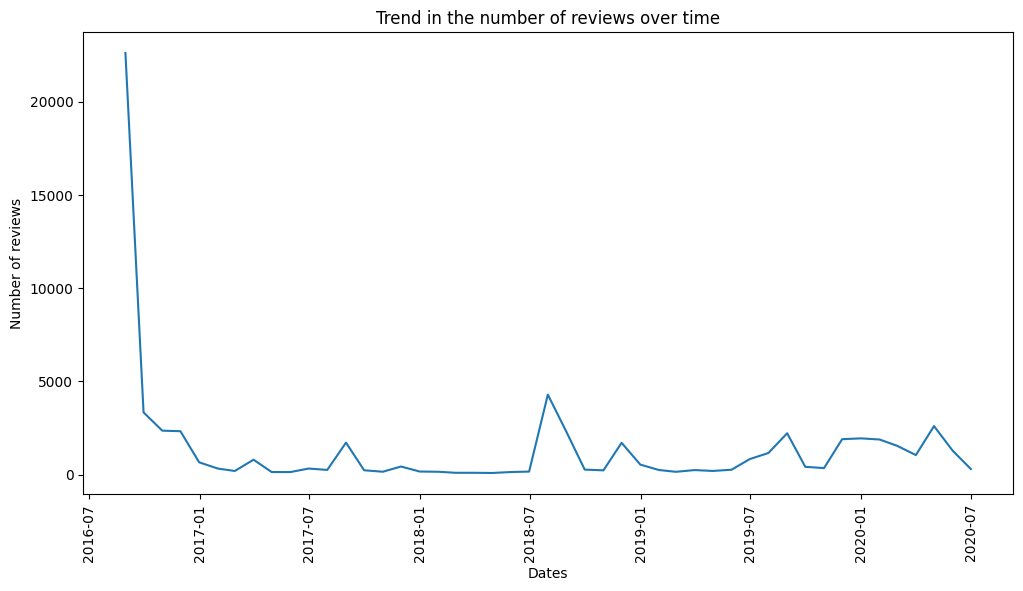

In [15]:
review_dates = game_dataset.select('timestamp_created').toPandas()
review_dates['timestamp_created'] = pd.to_datetime(review_dates['timestamp_created'])

review_count_by_date = review_dates.groupby(pd.Grouper(key='timestamp_created', freq='M')).size()

plt.figure(figsize=(12, 6))
plt.plot(review_count_by_date.index, review_count_by_date.values)
plt.xlabel('Dates')
plt.ylabel('Number of reviews')
plt.title('Trend in the number of reviews over time')
plt.xticks(rotation='vertical')
plt.show()


Now let's try to see how many reviews actually have been updated over time.

As we can see from the following line graph it suggests that users tend to edit or update their reviews less frequently than writing new reviews.

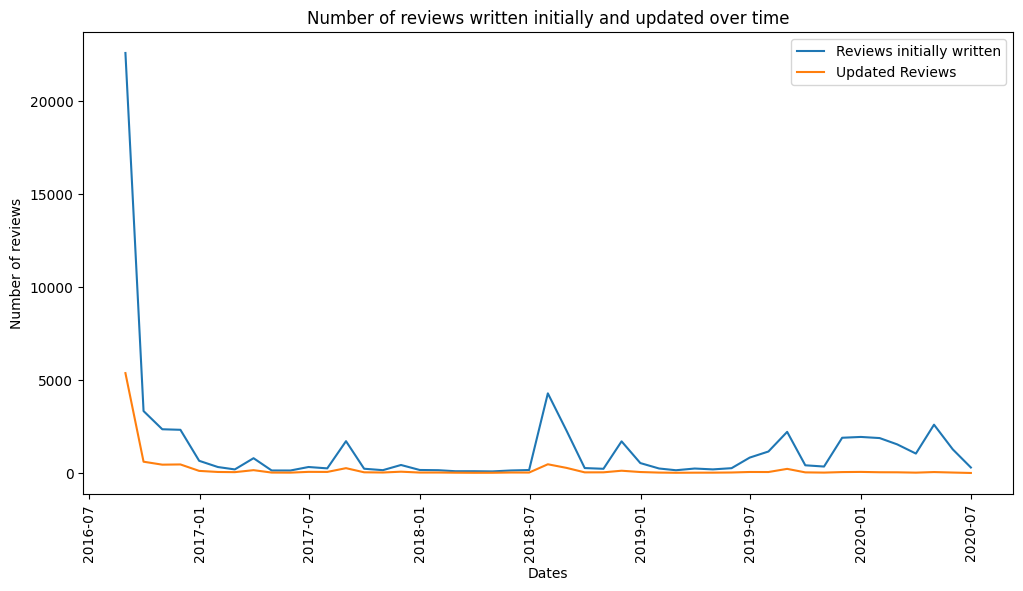

In [16]:
review_data = game_dataset.select('timestamp_created', 'timestamp_updated').toPandas()

review_data['timestamp_created'] = pd.to_datetime(review_data['timestamp_created'])
review_data['timestamp_updated'] = pd.to_datetime(review_data['timestamp_updated'])

# Create a column indicating whether or not a review has been updated.
review_data['review_status'] = review_data['timestamp_created'] != review_data['timestamp_updated']

# Group by month and count the number of reviews initially written and updated
review_count_by_month = review_data.groupby(pd.Grouper(key='timestamp_created', freq='M')).agg({
    'review_status': ['sum', 'count']
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(review_count_by_month['timestamp_created'], review_count_by_month[('review_status', 'count')], label='Reviews initially written')
plt.plot(review_count_by_month['timestamp_created'], review_count_by_month[('review_status', 'sum')], label='Updated Reviews')
plt.xlabel('Dates')
plt.ylabel('Number of reviews')
plt.title('Number of reviews written initially and updated over time')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()



###2.2.2) Distribution of the length of reviews

The following histogram provides an overview of the distribution of review lengths and can be used to better understand the text characteristics of reviews in the dataset.

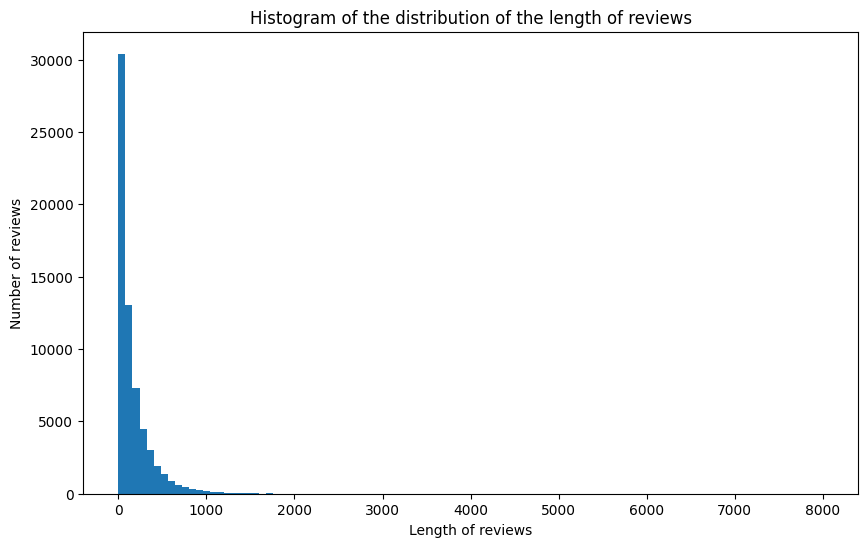

In [17]:
df_lengths = game_dataset.select('review', f.length('review').alias('review_length')).toPandas()
plt.figure(figsize=(10,6))

plt.hist(df_lengths['review_length'], bins=100)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Histogram of the distribution of the length of reviews')
plt.show()


### 2.2.3) Play time in the last two weeks VS Total play time

The following scatter plot displays a comparison of the authors' playing time over the past two weeks with the total playing time recorded in the dataset. The goal of this graph is to identify any relationships or patterns between recent play time and total play time.

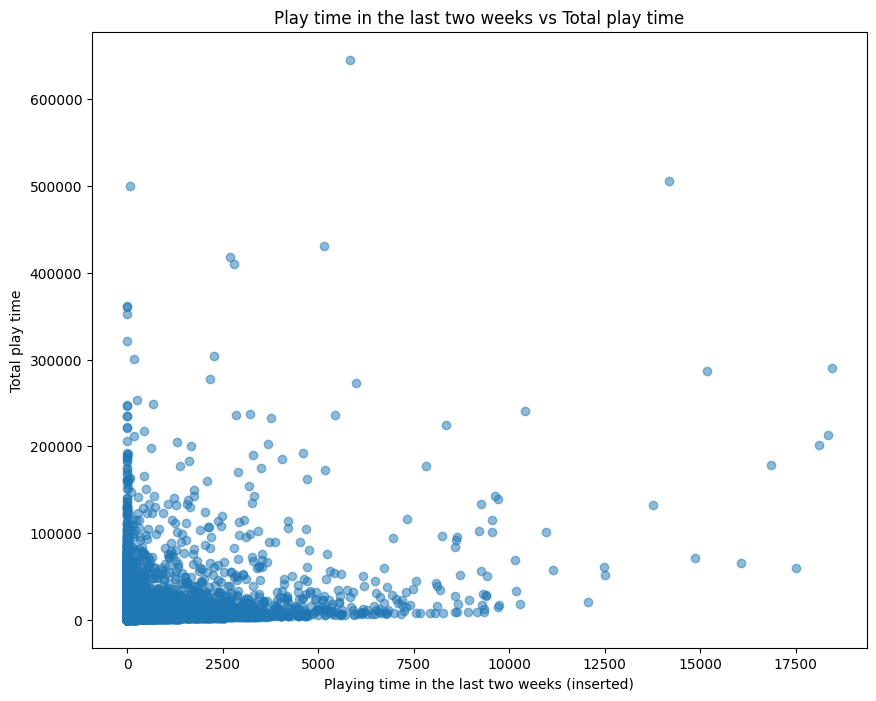

In [18]:
playtime_data = game_dataset.select('author_playtime_forever', 'author_playtime_last_two_weeks').toPandas()

plt.figure(figsize=(10, 8))
plt.scatter(playtime_data['author_playtime_last_two_weeks'], playtime_data['author_playtime_forever'], alpha=0.5)
plt.xlabel('Playing time in the last two weeks (inserted)')
plt.ylabel('Total play time')
plt.title('Play time in the last two weeks vs Total play time')
plt.show()


#3) Topic Modeling

For topic modelling, we need only textual data, thus, we create a new dataframe only with the column of interest.

In [19]:
text_col = ['recommendationid','review', 'votes_up']

review_text = game_dataset.select(text_col).filter(
    (f.col(text_col[0]).isNotNull()) & (f.col(text_col[1]).isNotNull())
)


##3.1) Text-processing + Pipeline with Unigrams
During the text processing phase, it is important to remove reviews that consist solely of special characters. This type of reviews does not provide useful information and can cause ambiguity in their interpretation. Removing these reviews ensures that the analyzed data is consistent and understandable. After the removal, other text processing techniques can be applied, such as tokenization, normalization, stopwords removal, n-gram extraction, and POS tagging, to obtain a structured representation of the text and facilitate the extraction of meaningful information.

We will start with **DocumentAssembler** that converts data into Spark NLP annotation format that can be used by Spark NLP annotators.

In [20]:
from sparknlp.base import DocumentAssembler

documentAssembler = DocumentAssembler() \
     .setInputCol('review') \
     .setOutputCol('document')

The next step is the **Tokenizer** that divides a text into smaller units called "tokens". This process is called "tokenization" and is used to split the text into words, phrases, or other meaningful units.

In [21]:
from sparknlp.annotator import Tokenizer

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

Now the **Normalizer** standardizes the text through various operations such as removing punctuation characters, converting to lowercase, and other transformations to obtain a normalized form of the text.

In [22]:
from sparknlp.annotator import Normalizer

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

The **LemmatizerModel** converts words to their base form or lemmas, reducing them to their canonical form, thereby reducing the complexity and variety of the words.

In [23]:
from sparknlp.annotator import LemmatizerModel

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [24]:
nltk.download('stopwords')

from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The downloaded list of stop words we will input into **StopWordsCleaner** that will remove all such words from our lemmatized text.

In [25]:
from sparknlp.annotator import StopWordsCleaner

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)

In addition to unigrams, I have decided to incorporate n-grams for topic modeling as well, as they help in further refining topics. **NGramGenerator** is used to generate these n-grams.

> Example **Unigram**: "game";

> Example N-gram:
>>**Bigrams** (2-grams): "natural language";
>>>**Trigrams** (3-grams): "text classification models";






In [26]:
from sparknlp.annotator import NGramGenerator

ngrammer = NGramGenerator() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

I chose to use the pre-trained **Perceptron** model provided by spark-nlp, it is a machine learning model used for Part-of-Speech (POS) tagging. It assigns grammatical categories to words in a sentence. The model uses a simplified neural network called perceptron and is trained on labeled examples to learn the patterns and weights for accurate word tagging.

In [27]:
from sparknlp.annotator import PerceptronModel

pos_tagger = PerceptronModel.pretrained('pos_anc') \
    .setInputCols(['document', 'lemmatized']) \
    .setOutputCol('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


Now trasform the data with the **Finisher**.

In [28]:
from sparknlp.base import Finisher

finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'pos'])

In [29]:
from pyspark.ml import Pipeline

pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 pos_tagger,
                 ngrammer,
                 finisher])

In [30]:
processed_review = pipeline.fit(review_text).transform(review_text)

In [31]:
processed_review.limit(5).show()

+----------------+--------------------+--------+--------------------+--------------------+--------------------+
|recommendationid|              review|votes_up|   finished_unigrams|     finished_ngrams|        finished_pos|
+----------------+--------------------+--------+--------------------+--------------------+--------------------+
|        70426209|game is k. random...|       0|[game, k, random,...|[game, be, k, ran...|[NN, VB, NN, JJ, ...|
|        70424273|you gotta grind f...|       0|[gotta, grind, ho...|[you, gotta, grin...|[PRP, VB, VB, IN,...|
|        70422255|             Awesome|       0|           [awesome]|           [awesome]|                [JJ]|
|        70420816|great exploration...|       0|[great, explorati...|[great, explorati...|[JJ, NN, JJ, NN, ...|
|        70419375|Its fun to just g...|       0|[fun, get, lose, ...|[it, fun, to, jus...|[PRP, NN, TO, RB,...|
+----------------+--------------------+--------+--------------------+--------------------+--------------

##3.2) Extended pipeline with N-grams
I think it is beneficial to incorporate n-grams into our NLP pipeline to improve the accuracy of topic modeling. However, currently the n-grams in our pipeline are disorganized and include many ambiguous combinations. To solve this problem, we can apply a filter based on grammatical categories (Part-of-Speech) to exclude odd word combinations and keep only relevant ones. For example, we can limit PoS combinations in n-grams to pairs such as adjective + noun,based on the purpose. In addition, we can exclude certain POS categories from our unigrams to avoid the use of functional words that might adversely affect topic modeling.

In [32]:
from pyspark.sql import types as t

udf_join_arr = f.udf(lambda x: ' '.join(x), t.StringType())
processed_review  = processed_review.withColumn('finished_pos', udf_join_arr(f.col('finished_pos')))

Next, we initiate another Spark NLP pipeline to obtain PoS tag n-grams that align with word n-grams.

> The pipeline to follow is the same as before but applied to the PoS tags
>>[D.Assembler->Tokenizer->N-Gram.Generator->Finisher]






In [33]:
pos_documentAssembler = DocumentAssembler() \
     .setInputCol('finished_pos') \
     .setOutputCol('pos_document')

In [34]:
pos_tokenizer = Tokenizer() \
     .setInputCols(['pos_document']) \
     .setOutputCol('pos')


Similarly, we generate n-grams from them using the same approach we employed for words.

In [35]:
pos_ngrammer = NGramGenerator() \
    .setInputCols(['pos']) \
    .setOutputCol('pos_ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

In [36]:
pos_finisher = Finisher() \
     .setInputCols(['pos', 'pos_ngrams'])

Now the creation of the new Pipeline

In [37]:
pos_pipeline = Pipeline() \
     .setStages([pos_documentAssembler,
                 pos_tokenizer,
                 pos_ngrammer,
                 pos_finisher])

In [38]:
processed_review = pos_pipeline.fit(processed_review).transform(processed_review)

Here are the word n-grams along with their corresponding PoS n-grams.

In [39]:
processed_review.select('finished_ngrams', 'finished_pos_ngrams').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We are now prepared to eliminate PoS tags from our data that are not useful for topic modeling analysis. Firstly, let's create a function specifically designed for filtering unigrams.
Ho deciso di escludere queste categorie di PoS tags non utili al mio studio :

> **Determiners**: DT such as "the", "a/an”, "this";

> **Personal Pronouns**: PRP such as "I", "you", "he/she";

> **Conjunctions**: CC such as "and", "but", "or";












In [40]:
def filter_pos(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags)
            if pos not in ['DT', 'PRP', 'CC']]

udf_filter_pos = f.udf(filter_pos, ArrayType(StringType()))

In [41]:
processed_review = processed_review.withColumn('filtered_unigrams',
                                               udf_filter_pos(f.col('finished_unigrams'),
                                                              f.col('finished_pos')))

This is the appearance of filtered unigrams.

In [42]:
processed_review.select('filtered_unigrams','review').limit(10).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_unigrams                                                                                                                           |review                                                                                                                                                                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------

Now exclude inappropriate combinations of PoS tags in n-grams. We will create the custom function using the same approach as before. Since we are working with bi- and trigrams, we have to limit the allowed POS tags for both cases.

In [43]:
def filter_pos_combs(words, pos_tags):
    return [
        word for word, pos in zip(words, pos_tags)
        if (
            len(pos.split('_')) == 2 and \
            pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP', 'VBZ','RB','VBN'] and \
            pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'RB','VBZ']
        ) \
        or (
            len(pos.split('_')) == 3 and \
            pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP', 'VBZ','RB','VBN'] and \
            pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'VB', 'VBP','VBZ','RB'] and \
            pos.split('_')[2] in ['NN', 'NNS']
        )
    ]

udf_filter_pos_combs = f.udf(filter_pos_combs, t.ArrayType(t.StringType()))

In [44]:
processed_review = processed_review.withColumn('filtered_ngrams',
                                               udf_filter_pos_combs(f.col('finished_ngrams'),
                                                                    f.col('finished_pos_ngrams')))

In [45]:
processed_review.select('filtered_ngrams').limit(10).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_ngrams                                                                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[be_k, k_random, random_gen, voice_act, get_old, swell_time, game_be_k, k_random_gen]                                                                                     |
|[sci_fi, fi_then, game_other, other_wise, wise_idk, other_wise_idk]                                                                                                       |
|[]                                                                                                                                    

So that we have unigrams and n-grams stored in separate columns in the dataframe, let's merge them together.

In [46]:
processed_review = processed_review.withColumn('final',
                                               f.concat(f.col('filtered_unigrams'),
                                                      f.col('filtered_ngrams')))

In [47]:
processed_review.select('final').limit(10).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[game, k, random, gen, preset, voice, act, old, none, less, swe

In [48]:
processed_review.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- review: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- finished_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final: array (nullable = true)
 |    |-- element: string (containsNull = true)



##3.3) Feature Extraction(TF-IDF)

The first is TF-IDF that is a document representation technique that combines two key concepts: **term frequency** (TF) and **inverse document frequency** (IDF).

Term Frequency (TF): Measures the frequency of a term within a specific document. The more frequently a term appears in a document, the higher its TF value will be for that document.

In [49]:
from pyspark.ml.feature import CountVectorizer

tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_review)
tf_result = tf_model.transform(processed_review)

Inverse Document Frequency (IDF): Measures the importance of a term in the entire document corpus. The IDF value of a term increases when it appears rarely in the corpus.

In [50]:
from pyspark.ml.feature import IDF

idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

In [51]:
tfidf_result.select('tf_idf_features').show(truncate=60)

+------------------------------------------------------------+
|                                             tf_idf_features|
+------------------------------------------------------------+
|(236156,[0,333,391,599,601,919,1461,2686,2918,3528,10061,...|
|(236156,[0,1,2,8,23,33,150,435,1653,1965,2325,2451,2521,3...|
|                          (236156,[157],[4.127597755610817])|
|(236156,[2,4,8,11,12,13,41,58,83,99,103,109,113,138,304,3...|
|(236156,[1,7,40,82,224,264,382,2943,7069,10491],[1.954283...|
|                      (236156,[131177],[10.385265343493456])|
|(236156,[0,2,3,7,11,20,27,30,39,65,148,166,232,384,389,45...|
|(236156,[0,7,9,11,40,43,87,97,123,205,448,2591,5071],[0.7...|
|(236156,[0,1,3,8,29,110,759,778,1132,1460,2074,3161,14336...|
|                          (236156,[545],[5.425923343784751])|
|     (236156,[4,340],[2.2244614225387904,4.869822497956773])|
|(236156,[22,176,2637,15216],[2.952781535576337,4.28382594...|
|(236156,[0,2,3,6,19,20,23,44,96,145,186,252,257,267,27

## 3.4) Principal Component Analysis (PCA)
PCA is a dimensionality reduction technique widely used in data analysis and machine learning. It allows us to transform a high-dimensional dataset into a lower-dimensional space while retaining as much information as possible.

In [92]:
from pyspark.ml.feature import PCA, StandardScaler

# Normalize the input data
scaler = StandardScaler(inputCol="tf_idf_features", outputCol="scaledFeatures",withStd=True, withMean=True)  #PCA is very sensitive to the scale of the input data, so we need to scale the data before applying PCA
tfidf_result = scaler.fit(tfidf_result).transform(tfidf_result)

In [93]:
K=10

In [ ]:
from pyspark.ml.feature import PCA

pca_model = PCA(k=K, inputCol="scaledFeatures", outputCol="pca_features")
pca_features = pca_model.fit(tfidf_result)
tfidf_result = pca_features.transform(tfidf_result).cache()

###3.4.1) Variance Distribution

In [ ]:
# returns the distribution of variance across eigenvectors
fig, ax = plt.subplots(1,1,figsize=(8,6))
_ = sns.barplot(x=[i for i in range(K)],
                y=pca_features.explainedVariance.values,
                ax=ax)
_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(["lambda_{:d}".format(i) for i in range(K)], rotation=45)

##3.5) Latent Dirichlet Allocation (LDA)
Now, we can proceed with the topic modeling using LDA on the dataset. For this algorithm, we need to specify the number of topics we believe are present in our data, as well as the number of iterations to run the LDA algorithm. Once we have set these parameters, we can initialize the LDA model and train it on our data.

To obtain a better understanding of each topic, we can specify the desired number of top words we want to examine.



During several trials for the topic generation process, I observed that when more than 10 topics are used, the coherence score tends to converge toward a value indicative of artificial coherence, that is, when it is too close to 1. Artificial coherence occurs when the generated topics appear to be consistent with each other, but may lack specificity or may not accurately reflect the information structure of the data.

Therefore, I decided to use a topic number of 10.

In [52]:
from pyspark.ml.clustering import LDA

num_topics = 10
max_iter = 30
num_top_words = 100

ldaTF = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
lda_modelTF = ldaTF.fit(tfidf_result)

In order to interpret and visualize the words that represent the identified topics, we need to convert the word IDs back into their corresponding actual words. To achieve this, we can define a custom function that performs this conversion.

In [53]:
vocab = tf_model.vocabulary

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]

udf_to_words = f.udf(get_words, t.ArrayType(t.StringType()))

In [54]:
topics = lda_modelTF.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(f.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|topicWords                      

##3.6) Measure of Topic Coherence Measure
The **topic coherence measure** provided by Gensim is a tool that evaluates the accuracy and coherence of topics generated by a topic model. It helps assess how interpretable and distinct the topics are from each other. The coherence measure compares the keywords within a topic and assesses their statistical or semantic coherence. By using methods like u_mass or c_v, the coherence measure calculates a score that reflects the coherence of the keywords.

In [55]:
# Merge word arrays into a single array for each topic
merged_words_df = topics.groupby("topic").agg(f.flatten(f.collect_list("topicWords")).alias("document"))

# Convert Spark DataFrame to a list of Python documents
document_list = merged_words_df.select("document").rdd.flatMap(lambda x: x[0]).collect()

In [56]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import json
import sys

output_file_json = "topicGenerationDEF.json"  # File JSON di output
output_file_txt = "topicGenerationDEF.txt"  # File TXT di output

# Creating the Gensim dictionary
topic_words_list = [row['topicWords'] for row in topics.collect()]
dictionary = Dictionary(topic_words_list)

# Open the JSON file to write the JSON data
with open(output_file_json, "w") as json_file:
    output_data = []

    for row in topics.collect():
        topic_id = row['topic']
        topic_words = row['topicWords']

        # Creating the Gensim corpus for the current topic.
        corpus = [dictionary.doc2bow(topic_words)]

        # Calculating the degree of consistency for the current topic.
        coherence_model = CoherenceModel(topics=[[word for word in topic_words]], texts=topic_words_list, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        topic_data = {
            "topic_id": topic_id,
            "coherence_score": round(coherence_score, 2),
            "top_words": topic_words
        }

        output_data.append(topic_data)

    json.dump(output_data, json_file)  # Write the JSON data to the file


df = pd.DataFrame(output_data)

with open(output_file_txt, "w") as txt_file:
    for topic_data in output_data:
        txt_file.write(f"Topic ID: {topic_data['topic_id']}\n")
        txt_file.write(f"Coherence Score: {topic_data['coherence_score']}\n")
        txt_file.write(f"Top Words: {', '.join(topic_data['top_words'])}\n")
        txt_file.write("\n")



##3.7) WordCloud
A wordcloud is a visual representation of the most frequent words in a text or body of text. It is an effective way to graphically visualize key words or major concepts found in a textual dataset.

In [57]:
df = spark.read.json("topicGenerationDEF.json")
topics_df = df.select('topic_id', 'coherence_score', 'top_words')

In [58]:
topics_df.printSchema()

root
 |-- topic_id: long (nullable = true)
 |-- coherence_score: double (nullable = true)
 |-- top_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



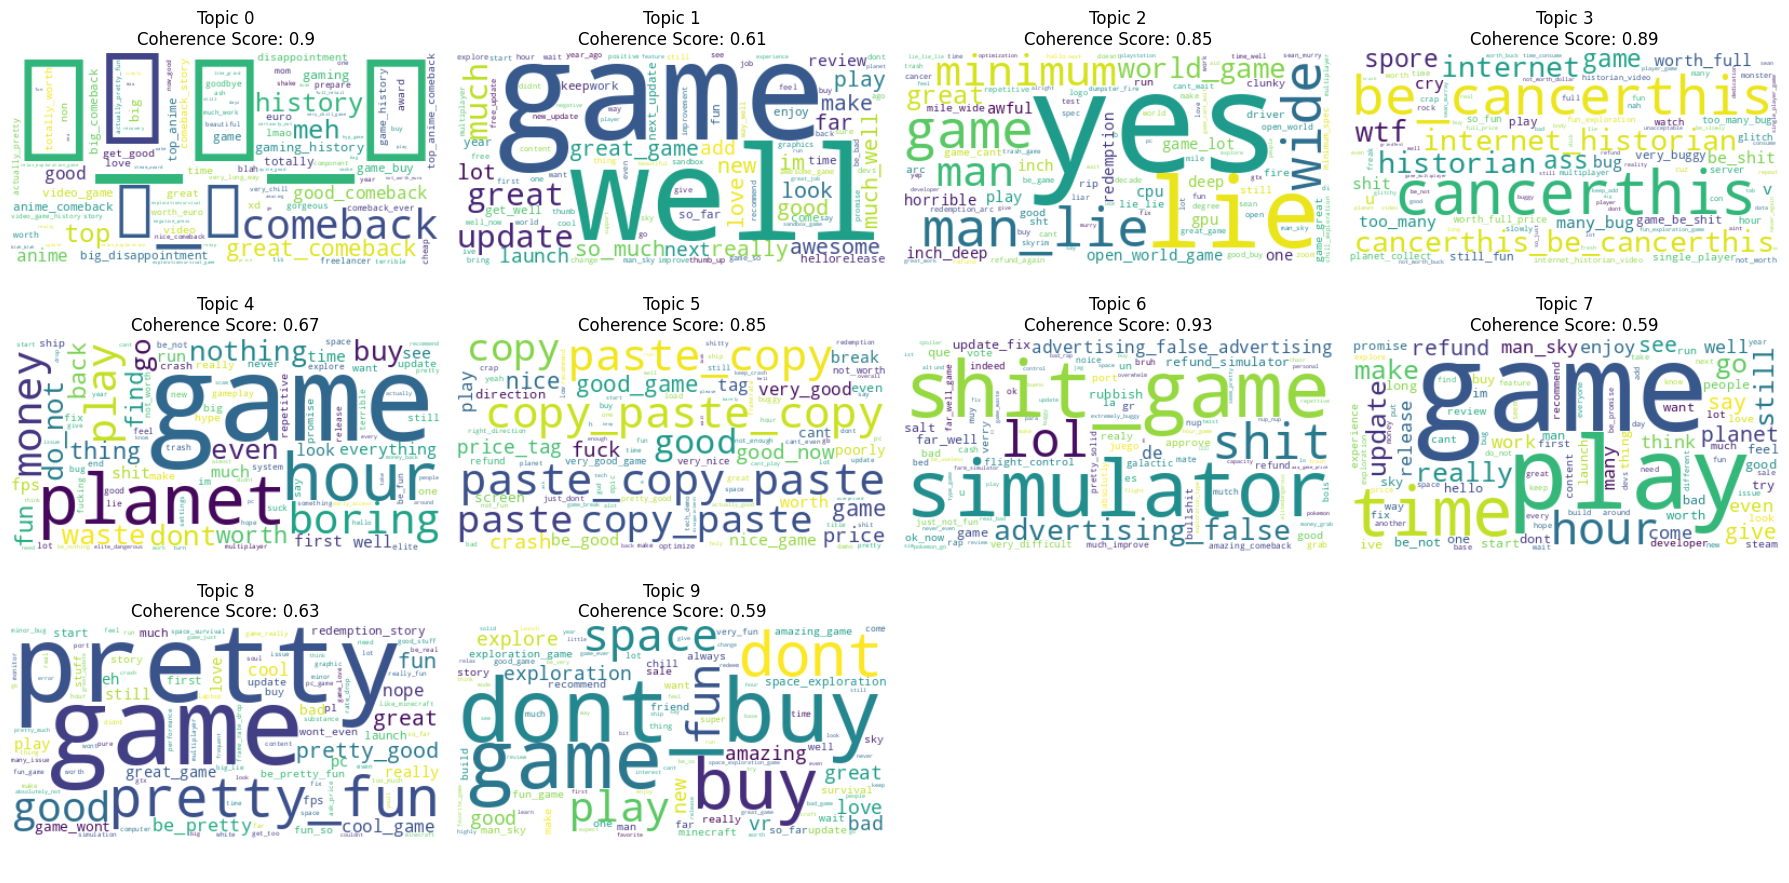

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert dataframe to a list of tuples (topic_id, coherence_score, top_words)
topic_data = topics_df.select("topic_id", "coherence_score", "top_words").collect()

# Calculates the total number of rows and columns for the grid.
num_topics = len(topic_data)
num_rows = (num_topics + 3) // 4
num_cols = min(num_topics, 4)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 3))

# Create word clouds for each topic and place them in the grid.
for i, topic in enumerate(topic_data):
    topic_id = topic.topic_id
    coherence_score = topic.coherence_score
    top_words = topic.top_words


    words_text = " ".join(top_words)


    wordcloud = WordCloud(background_color="white").generate(words_text)

    # Place the word cloud in the grid.
    if num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[i // num_cols, i % num_cols]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Topic {topic_id}\nCoherence Score: {coherence_score}")
    ax.axis("off")

# Remove empty axes if necessary.
if num_topics < num_rows * num_cols:
    for i in range(num_topics, num_rows * num_cols):
        if num_rows == 1 or num_cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // num_cols, i % num_cols]
        ax.axis("off")

# Adjusts the spacing between subplots.
fig.tight_layout()


plt.show()

##3.8) Topic Selection
I chose from these 10 topics the most representative ones based on the pre-requisites chosen at the beginning for this study:



> **FUNCTIONALITY**
*   POSITIVE (Topic ID 5): This topic seems to revolve around positive comments regarding the functionality of the game, such as smoothness, stability, and optimization. Users may have mentioned a seamless gaming experience and overall good performance of the game.
*   NEGATIVE (Topic ID 2): This topic appears to involve criticisms and negative comments about the game's functionality. It may address performance issues, bugs, poor optimization, or other technical difficulties that negatively affected users' gaming experience.


> **GAMEPLAY**
*   POSITIVE (Topic ID 0): This topic seems to focus on positive comments regarding the gameplay aspect of No Man's Sky. Users may have mentioned fun, quality of the gaming experience, interest in gameplay mechanics, exploration, and other positive features related to gameplay.
*   NEGATIVE (Topic ID 3): This topic contains criticisms and negative comments about the game's gameplay. It could include mentions of boredom, repetitiveness, lack of interesting content, or other negative aspects associated with the gaming experience.

> **USABILITY**
*   POSITIVE (Topic ID 9): This topic appears to discuss positive aspects regarding the usability of the game, such as ease of learning, intuitive interface, or other features that enhanced users' overall experience.
*   NEGATIVE (Topic ID 6): This topic seems to focus on criticisms or negative comments regarding the game's usability. It may address issues with navigation, difficult controls, a confusing interface, or other aspects that made interaction with the game challenging or frustrating.

**Others** (Topic ID 1,Topic ID 4,Topic ID 7): This topic doesn't clearly fit into the specified categories but may include miscellaneous comments and opinions that don't specifically focus on functionality, gameplay, or usability of the game. It could touch on various themes such as game purchase, price, gameplay expectations, or other general considerations.

#4) First Thesis of Machine Learning predictions
Does there exist a relationship between the **text of the review** and the **number of votes up** received? Can we predict this value with a Machine Learning model?

By training a model on this dataset, we can develop a classification system that can automatically identify and categorize reviews as either useful or not useful. This can ultimately help Steam display only the most relevant and valuable reviews to its users, enhancing their experience and aiding their purchasing decisions.

##4.1) Analysis of the distribution of votes_up column

**We consider as "useful reviews " only those reviews that exceed 96% of other ratings.**

In [60]:
game_dataset = game_dataset.withColumn("votes_up",f.col("votes_up").cast("integer"))

# Calculate the quantile on the column "votes_up"
votes_up_for_useful_review = game_dataset.approxQuantile("votes_up", [0.96], 0)[0]

df_selected = game_dataset.select("review", "votes_up")

In [61]:
distribution = df_selected.groupBy('votes_up').agg(f.count('*').alias('count')).orderBy('votes_up')
distribution.show(truncate=False)

+--------+-----+
|votes_up|count|
+--------+-----+
|0       |28715|
|1       |12177|
|2       |7102 |
|3       |4367 |
|4       |2914 |
|5       |2172 |
|6       |1543 |
|7       |1163 |
|8       |881  |
|9       |668  |
|10      |500  |
|11      |431  |
|12      |307  |
|13      |247  |
|14      |205  |
|15      |190  |
|16      |130  |
|17      |99   |
|18      |106  |
|19      |80   |
+--------+-----+
only showing top 20 rows



In [62]:
# Create a Spark DataFrame with useful reviews based on quantile value.
useful_reviews_df = game_dataset.filter(f.col('votes_up') >= votes_up_for_useful_review)

# Sampling a subset of unot useful reviews based on proportion.
not_useful_reviews_df = game_dataset.filter(f.col('votes_up') < votes_up_for_useful_review)

print("Reviews with votes_up values between [",useful_reviews_df.agg(f.min('votes_up')).collect()[0][0],",",useful_reviews_df.agg(f.max('votes_up')).collect()[0][0],"]")
print("Number of review not useful",not_useful_reviews_df.count())
print("Number of review useful",useful_reviews_df.count())


Reviews with votes_up values between [ 10 , 12236 ]
Number of review not useful 61702
Number of review useful 3055


In [63]:
# Merging DataFrames of useful and not-so-useful reviews.
restricted_df = useful_reviews_df.union(not_useful_reviews_df)

Defining the UDF function to assign the output label (0=not useful, 1=useful)

In [64]:
udf_y = f.udf(lambda x: 0 if x < votes_up_for_useful_review else 1, IntegerType())

# Add new column 'useful'
restricted_df = restricted_df.withColumn('useful', udf_y(f.col('votes_up')))

###4.1.1) Data Distribution before Balancing


In [65]:
df_useful = restricted_df.filter(restricted_df['useful'] == 1)
df_not_useful = restricted_df.filter(restricted_df['useful'] == 0)

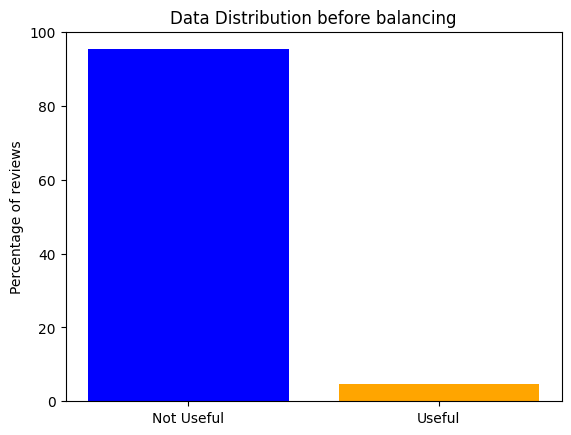

In [66]:
total_reviews = df_not_useful.count() + df_useful.count()
not_useful_percentage = (df_not_useful.count() / total_reviews) * 100
useful_percentage = (df_useful.count() / total_reviews) * 100

fig, ax = plt.subplots()
x = ['Not Useful', 'Useful']
y = [not_useful_percentage, useful_percentage]
ax.bar(x, y, color=['blue', 'orange'])
ax.set_ylabel('Percentage of reviews')
ax.set_title('Data Distribution before balancing')
plt.show()

### 4.1.2)Undersampling on not useful reviews
Since the dataframe is very unbalanced, given the clear majority and overwhelming power of the useful reviews, I decided to sub-sample on them, so as to have a ratio 50% for the not useful reviews, 50% for the useful.

Ratio is called **the weight factor**, calculates the ratio between the number of rows in the df_useful dataset and the number of rows in the df_not_useful dataset. This ratio represents the imbalance between useful and non-useful rows in the data. By calculating this, is possible to determine the relative weight or proportion of non-useful rows compared to useful rows.

In [67]:
ratio = float(df_useful.count()) / df_not_useful.count()
df_not_useful = df_not_useful.sample(False, ratio)
df_balanced = df_not_useful.unionAll(df_useful)

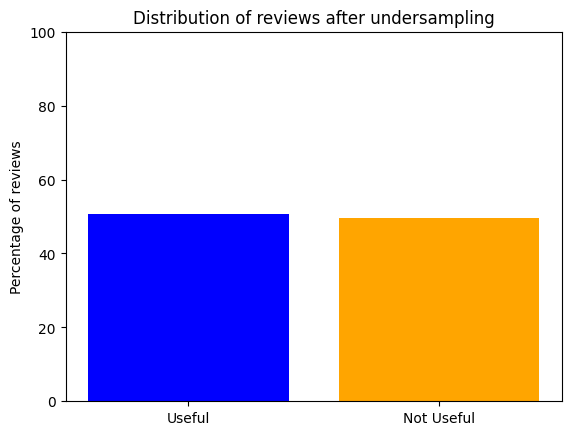

In [68]:
useful_df = df_balanced.select("useful").toPandas()

# Calculate the count
useful_count = useful_df[useful_df["useful"] == 1].count()[0]
not_useful_count = useful_df[useful_df["useful"] == 0].count()[0]

# Calculate normalized proportions
total_count = useful_count + not_useful_count
useful_percent = (useful_count / total_count) * 100
not_useful_percent = (not_useful_count / total_count) * 100

labels = ['Useful', 'Not Useful']
percentages = [useful_percent, not_useful_percent]
colors = ['blue', 'orange']

plt.bar(labels, percentages, color=colors)

plt.ylabel('Percentage of reviews')

plt.title('Distribution of reviews after undersampling')
plt.ylim(0, 100)
plt.show()


##4.2) Obtain the Bag-Of-Words(BoW)
The BoW is a common technique used in natural language processing (NLP) to represent text data into numbers. It simplifies the text by treating it as an unordered collection or "bag" of individual words.

In this case the cleaning is done differently since the sentences are only tokenized and the stop words are removed, the rest might be useful.

In [69]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

restricted_df = df_balanced.alias('restricted_df')

# Function to clean up text, this regex matches any string that contains only alphabet letters and spaces, with no other special characters or numbers.
def clean(input):
    import re
    return ''.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, list(re.sub('\n', ' ', input.lower())))))

udf_remove_not_characters = f.udf(clean, StringType())

# Apply the function
restricted_df = restricted_df.withColumn('cleaned_review', udf_remove_not_characters(f.col('review')))

# Tokenization - break review text into list of its individual terms (single words in this case)
tokenizer = Tokenizer(inputCol='cleaned_review', outputCol='review_words')
restricted_df = tokenizer.transform(restricted_df)

# Removing wordless reviews after tokenization
restricted_df = restricted_df.filter(f.size(f.col('review_words')) > 0)

# Removal of stop words
remover = StopWordsRemover(inputCol='review_words', outputCol='no_stop_words')
restricted_df = remover.transform(restricted_df)


Words such as 'going', 'went', 'gone' and 'goes' stem from the same word, 'go'. This process of converting words into their base form is called stemming. In text analysis, we use the stemming to reduce complexity.

In [70]:
from nltk.stem import SnowballStemmer

# Downloading data for NLTK's SnowballStemmer.
nltk.download('snowball_data')

[nltk_data] Downloading package snowball_data to /root/nltk_data...


True

In [71]:
from pyspark.ml.feature import CountVectorizer

# Stemmer creation.
stemmer = SnowballStemmer('english')

stemming_udf = f.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))

# Applying stemming to the dataframe
stemmed_df = restricted_df.withColumn('stemmed_review', stemming_udf(f.col('no_stop_words')))

# Creating the CountVectorizer instance.
count_vectorizer = CountVectorizer(inputCol='no_stop_words', outputCol='BoW')

# Training
model = count_vectorizer.fit(stemmed_df)
restricted_df = model.transform(stemmed_df)



In this case we can exclude all other columns because they are not useful for the purpose of classification.

In [72]:
columns_to_keep = ['recommendationid','review', 'cleaned_review', 'review_words', 'no_stop_words', 'stemmed_review', 'BoW', 'votes_up', 'useful']

restricted_df = restricted_df.select(*columns_to_keep)
restricted_df.printSchema()
restricted_df.head(1)

root
 |-- recommendationid: string (nullable = true)
 |-- review: string (nullable = true)
 |-- cleaned_review: string (nullable = true)
 |-- review_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- no_stop_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stemmed_review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- BoW: vector (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- useful: integer (nullable = true)



[Row(recommendationid='70416758', review='Fun game for exploring & building, i must also add that it works really well in VR', cleaned_review='fun game for exploring  building i must also add that it works really well in vr', review_words=['fun', 'game', 'for', 'exploring', '', 'building', 'i', 'must', 'also', 'add', 'that', 'it', 'works', 'really', 'well', 'in', 'vr'], no_stop_words=['fun', 'game', 'exploring', '', 'building', 'must', 'also', 'add', 'works', 'really', 'well', 'vr'], stemmed_review=['fun', 'game', 'explor', '', 'build', 'must', 'also', 'add', 'work', 'realli', 'well', 'vr'], BoW=SparseVector(9026, {0: 1.0, 1: 1.0, 8: 1.0, 12: 1.0, 61: 1.0, 88: 1.0, 112: 1.0, 173: 1.0, 211: 1.0, 232: 1.0, 353: 1.0, 450: 1.0}), votes_up=0, useful=0)]

In [91]:
restricted_df.select('BoW').show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                                       BoW|
+------------------------------------------------------------------------------------------+
|(9026,[0,1,8,12,61,88,112,173,211,232,353,450],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0...|
|(9026,[0,1,4,8,29,39,52,56,81,86,97,107,145,156,190,206,211,223,240,365,381,404,408,517...|
|                                                    (9026,[8,19,93,686],[1.0,1.0,1.0,1.0])|
| (9026,[1,4,55,219,224,719,1574,5589,6068,7760],[1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|                                                                 (9026,[59,166],[1.0,1.0])|
|                                         (9026,[0,14,529,5928,7531],[1.0,1.0,1.0,1.0,1.0])|
|(9026,[0,2,3,4,10,158,217,261,329,404,672,884,1058,1609,2280,3728,6142],[1.0,1.0,1.0,1....|
|                                                                 (902

##4.3) Make prediction using Machine Learning models

Now split the dataset in two sets:

1.   Train set
2.   Test Set


In [73]:
# Split the dataframe in two - train & test

trainDF, testDF = restricted_df.randomSplit([0.7, 0.3], seed=42)

from pyspark import StorageLevel
trainDF.persist(StorageLevel(True, True, True, True, 1))
testDF.persist(StorageLevel(True, True, True, True, 1))


DataFrame[recommendationid: string, review: string, cleaned_review: string, review_words: array<string>, no_stop_words: array<string>, stemmed_review: array<string>, BoW: vector, votes_up: int, useful: int]

In [74]:
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GBTClassifier,NaiveBayes,LinearSVC,MultilayerPerceptronClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report

In [75]:
evaluator = BinaryClassificationEvaluator(labelCol="useful", rawPredictionCol="prediction")
cols = ['useful', 'prediction']

For each machine learning model chosen, the following steps were performed:


1. The model is **instantiated** by specifying as a feature column ("BoW") and as a label column ("useful");
2.   The model is **trained** on the training set;
3.   The trained model is then used to **make predictions** on the test DataFrame, producing a prediction DataFrame;
4.   The evaluator evaluate the **performance of the model** by calculating a metric(example, accuracy);
5.   The classification_report function is used to generate a **report** showing other metrics;
6.   Finally, the function plot_confusion_matrix is used to plot a **confusion matrix** based on true labels and predicted labels, specifically for the model;


Cross Validation is used in the Logistic Regression,Decision Tree and Random Forest models.

###4.3.1) Logistic Regression

The code demonstrates the implementation of logistic regression for classification. Through cross-validation and parameter grid search, the best-performing logistic regression model is selected based on evaluation metrics and hyperparameter optimization.

In [76]:
lr_model = LogisticRegression(featuresCol='BoW', labelCol='useful',maxIter = 1000)

pipeline = Pipeline(stages = [lr_model])
paramGrid = ParamGridBuilder().addGrid(lr_model.regParam, [0.01, 0.1, 1.0]).addGrid(lr_model.maxIter, [10, 100, 1000]).build()
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossVal.fit(trainDF)
lr_bestModel = cvModel.bestModel

In [77]:
lr_predict = lr_bestModel.transform(testDF)
evaluator.evaluate(lr_predict)

lr_predict_pd = lr_predict.select(*cols).toPandas()

print(classification_report(lr_predict_pd['useful'], lr_predict_pd['prediction']))
print(evaluator.evaluate(lr_predict))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       899
           1       0.62      0.52      0.57       940

    accuracy                           0.59      1839
   macro avg       0.60      0.60      0.59      1839
weighted avg       0.60      0.59      0.59      1839

0.5961079686649469


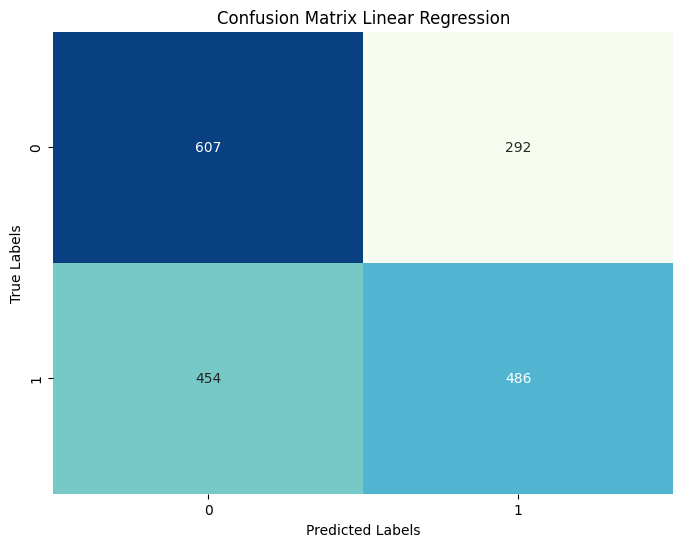

In [78]:
def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False)

    plt.title('Confusion Matrix ' + model_name)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.show()

plot_confusion_matrix(lr_predict_pd['useful'], lr_predict_pd['prediction'], "Linear Regression")

###4.3.2) Decision Tree
Decision tree is a supervised learning algorithm that learns a hierarchical structure of decisions and their possible outcomes. It partitions the data based on feature values to create a tree-like model, where each internal node represents a decision based on a specific feature, and each leaf node represents a predicted outcome or class label.

In [79]:
dt_model = DecisionTreeClassifier(featuresCol='BoW', labelCol='useful')

pipeline = Pipeline(stages=[dt_model])
paramGrid = ParamGridBuilder().addGrid(dt_model.maxDepth, [5, 10, 15]).build()
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossVal.fit(trainDF)
dt_bestModel = cvModel.bestModel

dt_predict = dt_bestModel.transform(testDF)
evaluator.evaluate(dt_predict)

dt_predict_pd = dt_predict.select(*cols).toPandas()

print(classification_report(dt_predict_pd['useful'], dt_predict_pd['prediction']))
print(evaluator.evaluate(dt_predict))


              precision    recall  f1-score   support

           0       0.55      0.61      0.58       899
           1       0.59      0.53      0.56       940

    accuracy                           0.57      1839
   macro avg       0.57      0.57      0.57      1839
weighted avg       0.57      0.57      0.57      1839

0.5702571415047453


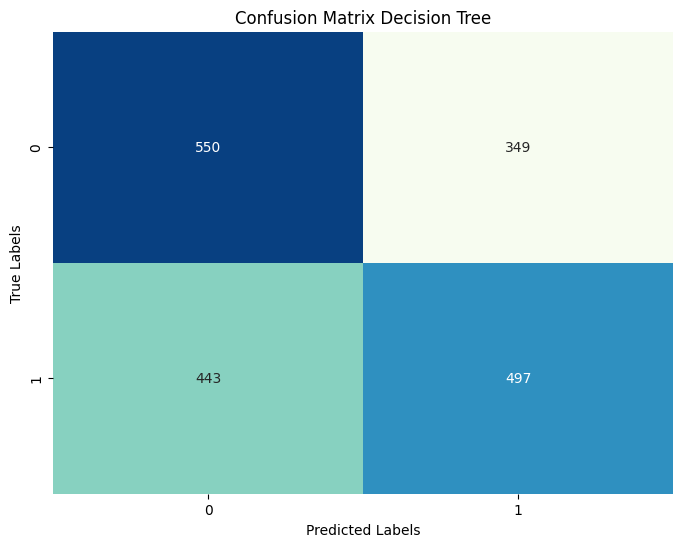

In [80]:
plot_confusion_matrix(dt_predict_pd['useful'], dt_predict_pd['prediction'],"Decision Tree")

###4.3.3) Random Forest
Random forest is an ensemble learning method that combines multiple decision trees to make predictions. The final prediction is determined by aggregating the predictions of individual trees.

In [81]:
rf_model = RandomForestClassifier(featuresCol='BoW', labelCol='useful')

pipeline = Pipeline(stages=[rf_model])
paramGrid = ParamGridBuilder().addGrid(rf_model.numTrees, [50, 100, 150]).addGrid(rf_model.maxDepth, [5, 10, 15]).build()
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossVal.fit(trainDF)
rf_bestModel = cvModel.bestModel

rf_predict = rf_bestModel.transform(testDF)
evaluator.evaluate(rf_predict)

rf_predict_pd = rf_predict.select(*cols).toPandas()

print(classification_report(rf_predict_pd['useful'], rf_predict_pd['prediction']))
print(evaluator.evaluate(rf_predict))


              precision    recall  f1-score   support

           0       0.58      0.66      0.62       899
           1       0.63      0.55      0.58       940

    accuracy                           0.60      1839
   macro avg       0.60      0.60      0.60      1839
weighted avg       0.60      0.60      0.60      1839

0.602102809267981


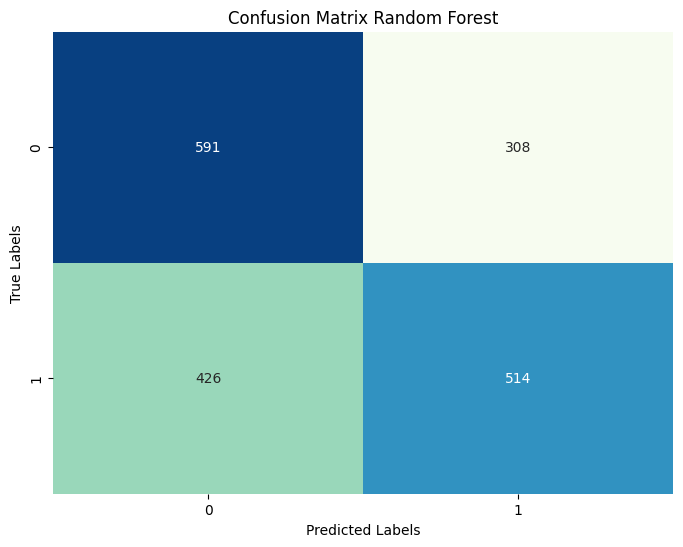

In [82]:
plot_confusion_matrix(rf_predict_pd['useful'],rf_predict_pd['prediction'],"Random Forest")

### 4.3.4) Naive Bayes
Naive Bayes is a probabilistic classification algorithm based on Bayes' theorem with a strong assumption of feature independence. It calculates the probability of each class label given the input features and selects the class label with the highest probability.

In [83]:
nb_model = NaiveBayes(featuresCol="BoW", labelCol="useful")
naiveBayes_model = nb_model.fit(trainDF)

In [84]:
nb_predict = naiveBayes_model.transform(testDF)
evaluator.evaluate(nb_predict)

nb_predict_pd = nb_predict.select(*cols).toPandas()

print(classification_report(nb_predict_pd['useful'], nb_predict_pd['prediction']))
print(evaluator.evaluate(nb_predict))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       899
           1       0.63      0.64      0.64       940

    accuracy                           0.63      1839
   macro avg       0.63      0.63      0.63      1839
weighted avg       0.63      0.63      0.63      1839

0.6272205523868128


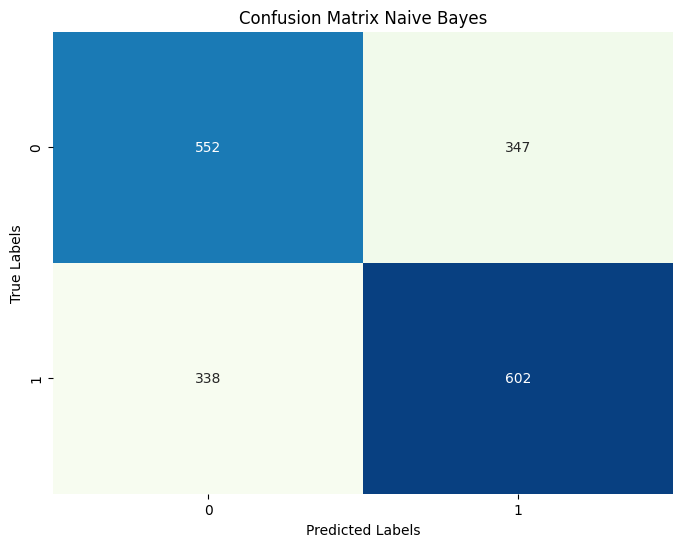

In [85]:
plot_confusion_matrix(nb_predict_pd['useful'], nb_predict_pd['prediction'], "Naive Bayes")

###4.3.5)Support Vector Classifier
A supervised learning algorithm that performs binary classification by constructing a linear decision boundary. It aims to find the best hyperplane that separates the data points into different classes while maximizing the margin.

In [86]:
lsvc_model = LinearSVC(maxIter=10000, regParam=0.1, featuresCol="BoW", labelCol="useful")
lsvc_model = lsvc_model.fit(trainDF)

lsvc_predictions = lsvc_model.transform(testDF)
evaluator.evaluate(lsvc_predictions)

lsvc_predictions_pd = lsvc_predictions.select(*cols).toPandas()

print(classification_report(lsvc_predictions_pd['useful'], lsvc_predictions_pd['prediction']))
print(evaluator.evaluate(lsvc_predictions))

              precision    recall  f1-score   support

           0       0.57      0.67      0.61       899
           1       0.62      0.51      0.56       940

    accuracy                           0.59      1839
   macro avg       0.59      0.59      0.59      1839
weighted avg       0.59      0.59      0.58      1839

0.5891445577828793


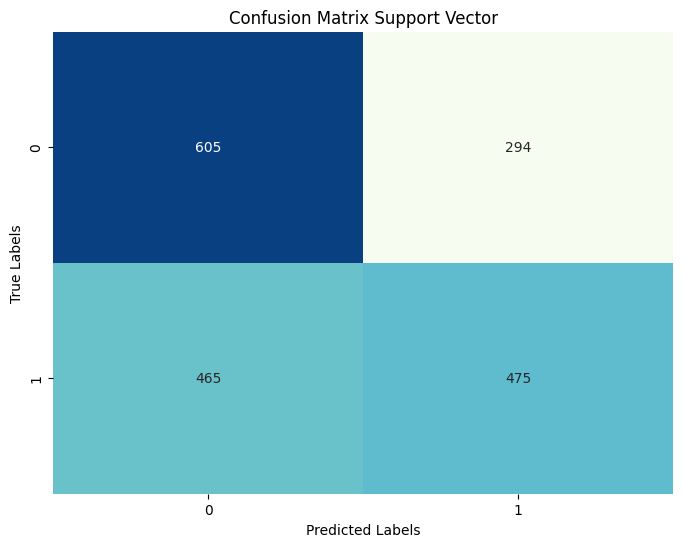

In [87]:
plot_confusion_matrix(lsvc_predictions_pd['useful'], lsvc_predictions_pd['prediction'], "Support Vector")

###4.3.6)Gradient Boost Tree
Gradient Boosting Tree is an ensemble learning technique that builds an additive model by combining multiple decision trees in a stage-wise manner. It trains each tree to correct the mistakes made by the previous trees, optimizing a loss function.

In [88]:
gbt_model = GBTClassifier(featuresCol="BoW", labelCol="useful")
gbt_classifier = gbt_model.fit(trainDF)

In [89]:
gbt_predict = gbt_classifier.transform(testDF)
evaluator.evaluate(gbt_predict)

gbt_predict_pd = gbt_predict.select(*cols).toPandas()
report = classification_report(gbt_predict_pd['useful'], gbt_predict_pd['prediction'])
print(report)
print(evaluator.evaluate(gbt_predict))

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       899
           1       0.60      0.57      0.59       940

    accuracy                           0.59      1839
   macro avg       0.59      0.59      0.59      1839
weighted avg       0.59      0.59      0.59      1839

0.5893818190424349


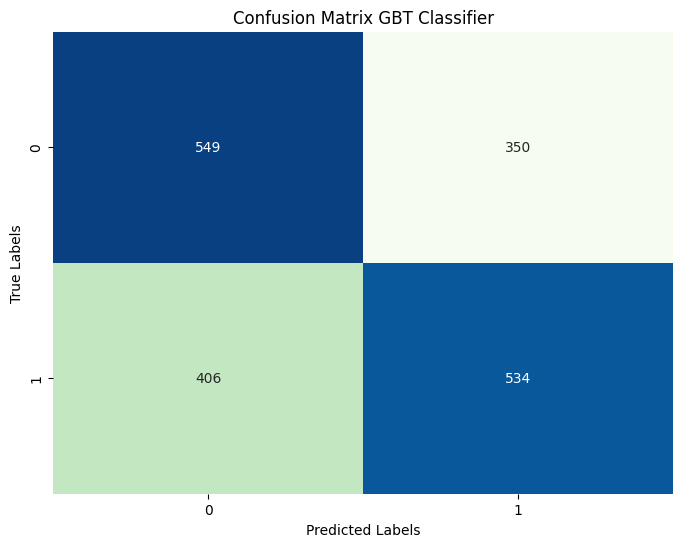

In [90]:
plot_confusion_matrix(gbt_predict_pd['useful'], gbt_predict_pd['prediction'], "GBT Classifier")